# パラメーター化された量子回路

この節ではパラメーター化された量子回路について紹介し、量子機械学習における性質や実装例を説明します。 

## はじめに

ゲートが調整可能なパラメーターによって定義されるパラメーター化された量子回路は、短期的な量子機械学習アルゴリズムの基本的な構成要素です。 文献では、文脈に応じて、パラメーター化された量子回路は、パラメーター化された試行状態、変分形式、またはansats とも呼ばれます。

以下はシンプルなパラメーター化された回路の例です。2つのパラメーター化されたゲートがあり、回転角 $\theta$ の1量子ビットの $z$ 回転ゲートの後に同じく回転角 $\theta$ の2量子ビット制御 $z$ 回転ゲートが続いています。

![量子ビット0にRZ（シータ）ゲートがあり、量子ビット1をターゲットとする量子ビット0によって制御されるCRZ（シータ）が続く量子回路](images/pqc/0.svg)

`QuantumCircuit` クラスと `Parameter` クラスを使用して、上記のパラメーター化された回路を作成できます。 `Parameter` クラスを使用すると、角度を指定しなくても、回転ゲートを追加できます。

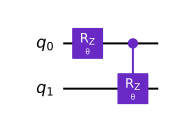

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter
theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta, 0)
qc.crz(theta, 0, 1)
qc.draw()

ゲートに異なるパラメーターを持たせたい場合は、2つの`Parameters`を使用するか、 `Parameters`のリストのように機能する`ParameterVector`を作成します。

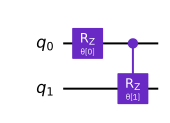

In [2]:
from qiskit.circuit import ParameterVector
theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0], 0)
qc.crz(theta_list[1], 0, 1)
qc.draw()

量子回路で使用されるすべての量子ゲートは [ユニタリー](gloss:unitary) であるため、パラメーター化された回路自体は、 $n$ 量子ビットの初期状態 $|\phi_0\rangle$ に作用するユニタリー操作 $\mathbf{U_\theta}$ として説明できます。 初期状態は多くの場合 $|0\rangle^{\otimes n}$ に設定されます。結果として得られるパラメーター化された量子状態は、 $|\psi_\mathbf{\theta}\rangle = \mathbf{U_\theta} |\phi_0\rangle$ です。ここで、 $\mathbf{\theta}$ は調整可能なパラメーターのセットです。

<!-- ::: q-block.exercise -->

### クイッククイズ

<!-- ::: q-quiz(goal="qml-pqc-0") -->

<!-- ::: .question -->

パラメーター化された量子回路が近い将来(near-term)の機械学習アルゴリズムに役立つのはなぜですか？

<!-- ::: -->

<!-- ::: .option(correct) -->

1. パラメーター化された量子回路は、近い将来の量子デバイスへのアルゴリズムの実装を可能にするから

<!-- ::: -->

<!-- ::: .option -->

1. パラメーター化された量子回路は古典データをエンコードすることができないから

<!-- ::: -->

<!-- ::: .option -->

1. パラメーター化された量子回路は、複雑な量子状態を表現できないから

<!-- ::: -->

<!-- ::: -->

<!-- ::: -->

## パラメーター化された量子回路の特性

パラメーター化された回路をいくつかの選択肢から選ぶ場合、どのように選べばよいでしょうか？パラメーター化された量子回路を機械学習モデルとして使用するには、適切に一般化する必要があります。これは、回路が出力[ヒルベルト空間](gloss:hilbert-space)内で意味のある状態のサブセットを生成できる必要があることを指しています。また、古典コンピューターで簡単にシミュレートできないように、回路はエンタングルした量子ビットを持つ必要があります。

参考文献1で、著者は、異なるパラメーター化された量子回路を区別するための*表現能力*と*エンタングリング能力*という尺度を提案しています。回路の*表現能力*とは、ヒルベルト空間内で状態を生成できる範囲と考えることができますが、回路の*エンタングリング能力*は、エンタングルされた状態を生成する能力を表します。

### 表現能力

パラメーター化された量子回路の*表現能力*とは、本質的に、回路の仮説空間によるヒルベルト空間のカバレッジです。表現能力の高いパラメーター化された量子回路は、多くの異なるユニタリーを表現することができます。この表現能力を表す方法はたくさんあり、参考文献1ではその例の1つが示されています。ここで、著者は、回路から生成された状態が[一様分布](gloss:uniform-distribution)から逸脱する程度を計算することによって、表現能力を定量化しています。

次の2つの単一量子ビット回路を比較して、各回路の2000の出力状態をサンプリングし、それらをブロッホ球にプロットすることによって、回路に表現能力があるかどうかを理解しましょう。

![2つの単一量子ビット量子回路。回路「A」には、1つのHゲートとそれに続くRZ（シータ）ゲートがあります。回路「B」には、Hゲート、RZ（シータ）ゲート、RX（ファイ）ゲートが続きます。](images/pqc/1.svg)

<!-- ::: q-block -->

### 表現能力の探求

    q-mini-composer(goal="pqc-minicomposer")
        .slide
            .circuit
                .autoMeasureGate
                .availableGates H RZ(theta)
                .initialCircuit
                    .qubit
                .goalCircuit
                    .qubit H RZ(theta)
            .instructions 'Circuit A' を再度作ってください
            .lesson この回路では、少数の状態にしかアクセスできません。<br><img src="images/pqc/bloch_a.gif"><br>上に、θのランダムな値に対するいくつかの出力状態をプロットしました。
            .info いいですね! どんどん実験していきましょう。
        .slide
            .circuit
                .autoMeasureGate
                .availableGates RX(phi)
                .initialCircuit
                    .qubit H RZ(theta)
                .goalCircuit
                    .qubit H RZ(theta) RX(phi)
            .instructions 'Circuit B' を再度作ってください
            .lesson このゲートの追加で、より多くの状態にアクセスできるようになりました。<br><img src="images/pqc/bloch_b.gif"><br>上では、θとΦのランダムな値に対するいくつかの出力状態をプロットしました。
            .info おめでとうございます!
<!-- ::: -->

出力状態がブロッホ球の赤道付近に分布しています。一方で追加のパラメーター化された$z$回転ゲートを使用した回路Bでは、すべてのブロッホ球を出力状態でカバーできますが、カバー範囲は均一ではありません。ブロッホ球の $+X$ 極と $-X$ 極に点が集中しています。

表現能力は、これらの単一量子ビット回路で観察されたものを定量化する方法です。回路Aは、探索できる状態のセットが限られているため、表現能力のスコアが低くなりますが、回路Bは表現能力のスコアが高くなります。 

<!-- ::: q-block.reminder -->

### 追加のコード

<details>
    <summary>上記の演習で使用したブロッホ球プロットを生成するコード</summary>

```python3
import numpy as np
import matplotlib.pyplot as plt

# First, we need to define the circuits:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)

# Circuit B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)

# Next we uniformly sample the parameter space for the two parameters theta and phi
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Then we take the parameter value lists, build the state vectors corresponding
# to each circuit, and plot them on the Bloch sphere:
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))

b1.show()
b2.show()
```
</details>

<!-- ::: -->

### エンタングリング能力

エンタングルメントは、量子コンピューティングの重要なリソースです。 <br>量子状態のエンタングルの度合いを測る数多くの指標の一つとして[Meyer-Wallach測度](gloss:meyer-wallach-measure)があります。Meyer-Wallach測度はエンタングルされていない[積状態](gloss:product-state)では0ですが、ベル状態などの高度にエンタングルされた状態では1をとります。参考文献1で、著者はパラメーター化された量子回路のエンタングリング能力を回路から生成し得る状態のMeyer-Wallach測度の平均と定義しています。

たとえば、次の複数量子ビットのパラメーター化回路について考えてみます。

![2つの4量子ビット量子回路。回路「A」には、各量子ビットにRZゲートがあり、その後に各量子ビットにRXゲートがあります。回路「B」は回路Aと同じですが、量子ビット0＆1、2＆3、1＆2の順に作用する3つの追加のCNOTゲートが続きます。](images/pqc/2.svg)

回路Aには、エンタングル操作、つまり2量子ビットゲートがないため、エンタングリング能力がありません。したがって、この回路は、Meyer-Wallachの測定値が0の状態を生成し、その平均値は0になります。回路Bでは2量子ビットのゲートがいくつかあるため、エンタングルされた量子状態を生成できます。したがって、Meyer-Wallachの平均測定値は0より大きくなります。 

表現能力とエンタングル能力という2つのパラメーター化された回路の記述子を用いて回路の能力の制約を知ることが出来ます。制約のある回路は、量子機械学習アプリケーションの候補としては不十分であると予想されます。参考文献2では、[変分量子分類器](gloss:variational-quantum-classifier)について研究されていて、そのデータセットとパラメーター化された回路については、分類精度と表現能力との間に強い相関関係があり、分類精度のエンタングリング能力との間には弱い相関関係があることが報告されています。

### ハードウェア効率

近い将来の量子コンピューティングの時代では、デバイスは[量子ビットの接続](gloss:qubit-connectivity)に制限が存在しているため、[コヒーレンス時間](gloss:qubit-connectivity)やゲートのフィデリティー、回路の深さが結果の精度に直結します。というのも限られたエラー訂正や緩和の方法しか存在しないからです。

参考文献3は、デバイスの制約に対応するためのハードウェア効率の高いパラメーター化された回路のクラスを提唱しています。これらの回路の共通の特徴は、量子ビットの結合トポロジーだけでなく、量子ゲートも特定のものに絞っている点です。量子ゲートは通常、1つの2量子ビットエンタングルゲートと最大3つの量子ビットゲートで構成されます。次に、回路は、複数またはすべての量子ビットに並列に適用される単一量子ビットゲートとエンタングルゲートのブロックから構築されます。単一量子ビットとエンタングルゲートのシーケンスはレイヤーと呼ばれ、パラメーター化された回路は一般に複数のレイヤーを持っています。

「エンタングリング能力」のセクションに示されている回路B（以下にも示されています）は、ハードウェア効率の高いレイヤーを一つ持つパラメーター化された回路の例です。

![回路「B」には、Hゲート、RZ（シータ）ゲート、RX（ファイ）ゲートが続きます。](images/pqc/circuit-b.svg)

<!-- ::: q-block.exercise -->

### クイッククイズ

    q-carousel
        q-quiz(goal="qml-pqc-quizousel-0")
            .question.md _表現能力_ で説明しているのは...
            .option(x) パラメーター化された回路がヒルベルト空間内で状態を生成できる範囲
            .option 近い将来の量子ハードウェアで回路がどれだけうまく機能するか
            .option エンタングルされた状態を生成するパラメーター化された回路の能力

        q-quiz(goal="qml-pqc-quizousel-1")
            .question.md _エンタングリング能力_ で説明しているのは...
            .option パラメーター化された回路がヒルベルト空間内で状態を生成できる範囲
            .option 近い将来の量子ハードウェアで回路がどれだけうまく機能するか
            .option(x) エンタングルされた状態を生成するパラメーター化された回路の能力

        q-quiz(goal="qml-pqc-quizousel-2")
            .question.md _ハードウェア効率_ で説明しているのは...
            .option パラメーター化された回路がヒルベルト空間内で状態を生成できる範囲
            .option(x) 近い将来の量子ハードウェアで回路がどれだけうまく機能するか
            .option エンタングルされた状態を生成するパラメーター化された回路の能力

<!-- ::: -->

## 機械学習のためのパラメーター化された量子回路

量子機械学習では、パラメーター化された量子回路は次の2つの目的で使用される傾向があります。

- データのエンコード：パラメーターはエンコードされるデータによって決定される
- 量子モデル：パラメーターは最適化処理によって決定される

ここでは、Qiskitを使用して量子機械学習の文献で使用されるパラメーター化された量子回路を構築する方法の例をいくつか示します。 

参考文献4で、著者はデータのエンコードに使用される次のパラメーター化された回路を紹介します。これについては[後で](./quantum-feature-maps-kernels)詳しく説明します。

$$
\mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right),
$$

上式は、アダマールゲートをエンタングルブロック $U_{\Phi(\mathbf{x})}$ でインターリーブした層が含まれています。このユニタリー演算は古典的には計算が困難であるが、近い将来のハードウェアでは扱いやすいという理由で選ばれています。 エンタングルブロックの中で、$U_{\Phi(\mathbf{x})}$: $P_i \in { I, X, Y, Z }$ はパウリ行列を示し、インデックス $S$ は異なる量子ビットの間の接続性を記述しています： $S \in {\binom{n}{k}\ \text{combinations},\ k = 1,... n }$ 、また、データマッピング関数の $\phi_S(\mathbf{x})$ は以下です。
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$
    
具体的には、$k = 2, P_0 = Z, P_1 = ZZ$を使用します。これは、Qiskitでは[`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)回路です。

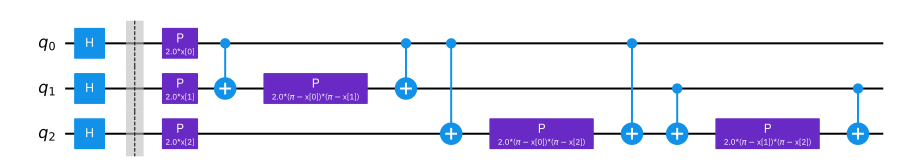

In [3]:
from qiskit.circuit.library import ZZFeatureMap
qc_zz = ZZFeatureMap(3, reps=1, insert_barriers=True)
qc_zz.decompose().draw()

参考文献4では、著者は、ハードウェア効率の高い回路を量子モデルとして使用しています。これは、単一量子ビットの回転ゲートとそれに続く2量子ビットゲートを交互に重ねた層で構成されています。特に、それらは$y$および$z$回転ゲート、および制御$z$ゲートを使用します。これらは、 [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html)回路を使用して構築できます。

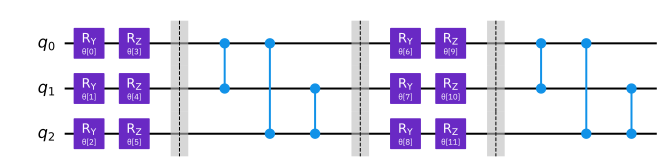

In [4]:
from qiskit.circuit.library import TwoLocal
qc_twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=True,
                insert_barriers=True)

qc_twolocal.decompose().draw()

Qiskitの `TwoLocal` 回路は、参考文献1の回路13など、様々なパラメーター化された回路を作成できます。

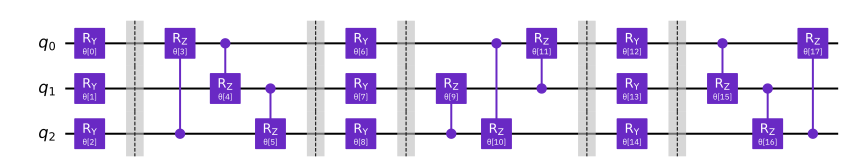

In [5]:
qc_13 = TwoLocal(3, rotation_blocks='ry',
                 entanglement_blocks='crz', entanglement='sca',
                 reps=3, skip_final_rotation_layer=True,
                 insert_barriers=True)

qc_13.decompose().draw()

Qiskitの [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) 回路は、回転レイヤーとエンタングルレイヤーが交互になった、より一般的なパラメーター化された回路を作成することもできます。

以下が `NLocal` 回路の例で、2量子ビットの回転ブロックと、線形エンタングルメントを使用した4量子ビットのエンタングルブロックがあります。

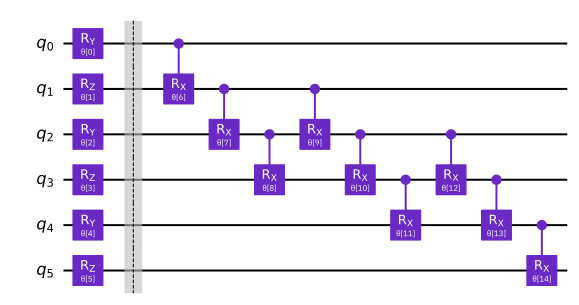

In [6]:
from qiskit.circuit.library import NLocal

# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4)
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

qc_nlocal = NLocal(num_qubits=6, rotation_blocks=rot,
                   entanglement_blocks=ent, entanglement='linear',
                   skip_final_rotation_layer=True, insert_barriers=True)

qc_nlocal.decompose().draw()

<!-- ::: q-block.exercise -->

### 試してみよう

IBMQuantumLabの [QiskitCircuitLibrary](https://quantum-computing.ibm.com/lab) にある [NLocalCircuits](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits) または [DataEncodingCircuits](https://qiskit.org/documentation/apidoc/circuit_library.html#data-encoding-circuits) のいずれかを使用して、独自のパラメーター化された量子回路を構築してみてください。

<!-- ::: -->

## 参考文献

<!-- vale QiskitTextbook.Spelling = NO -->

1. Sukin Sim、Peter D. Johnson、Alan Aspuru-Guzik、*Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms*、Advanced Quantum Technology 2（2019）1900070、 [doi：10.1002 / qute.201900070](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.201900070) 、 [arXiv：1905.10876](https://arxiv.org/abs/1905.10876) 。
2. Thomas Hubregtsen, Josef Pichlmeier, and Koen Bertels, *Evaluation of Parameterized Quantum Circuits: On the Design, and the Relation between Classification Accuracy, Expressibility and Entangling Capability* 2020, [arXiv:2003.09887](https://arxiv.org/abs/2003.09887).
3. Abhinav Kandala, Antonio Mezzacapo, Kristan Temme, Maika Takita, Markus Brink, Jerry M. Chow and Jay M. Gambetta, *Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets*, Nature 549, 242–246 (2017), [doi.org/10.1038/nature23879](https://doi.org/10.1038/nature23879), [arXiv:1704.05018](https://arxiv.org/abs/1704.05018)
4. Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow and Jay M. Gambetta, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209-212 (2019), [doi.org:10.1038/s41586-019-0980-2](https://doi.org/10.1038/s41586-019-0980-2), [arXiv:1804.11326](https://arxiv.org/abs/1804.11326).

In [7]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
